hog feature len 7056


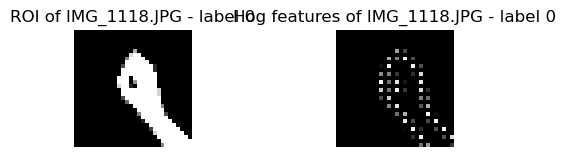

hog feature len 7056


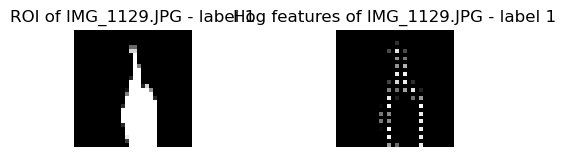

hog feature len 7056


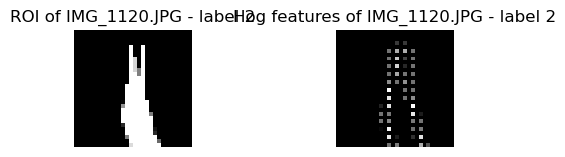

hog feature len 7056


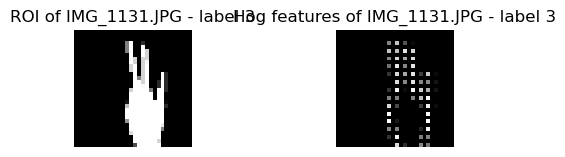

hog feature len 7056


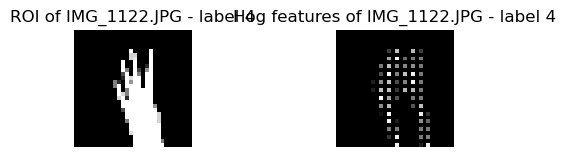

hog feature len 7056


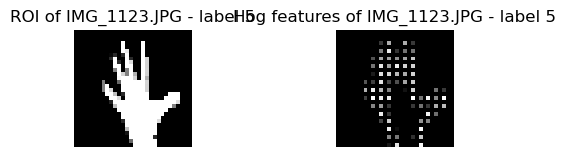

hog feature len 7056


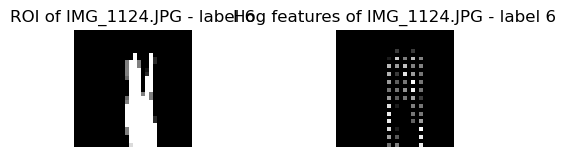

hog feature len 7056


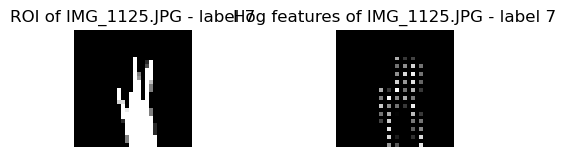

hog feature len 7056


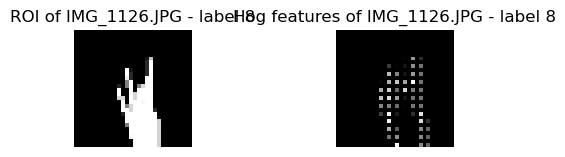

hog feature len 7056


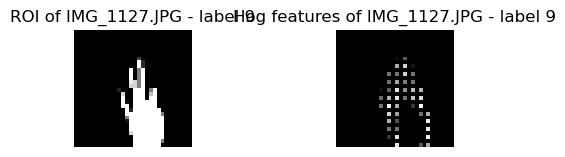

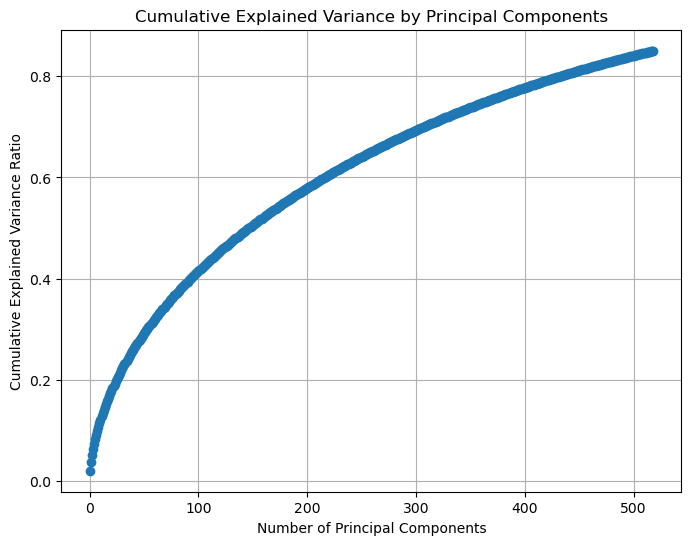

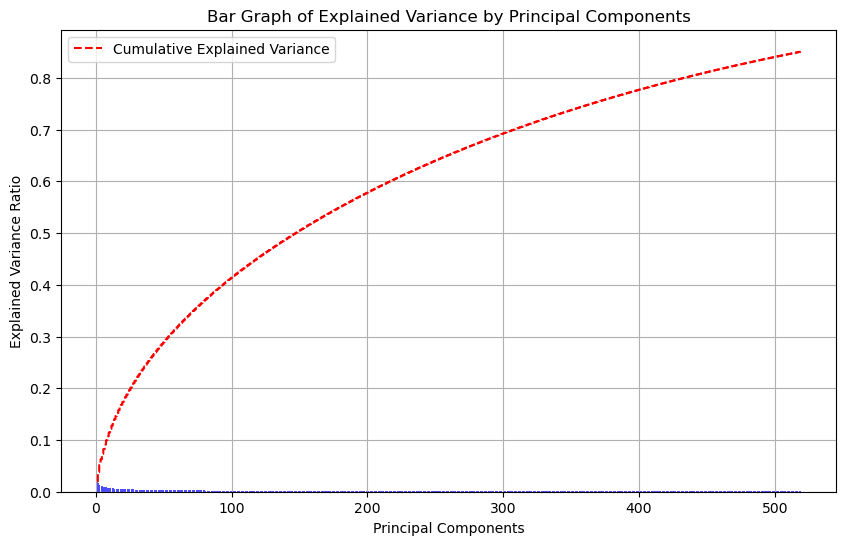

In [ ]:
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from functions import GLCMCalculator, imagePreprocessing, imageSegmentation, writeFeaturesToCSV

def HOGCalculator(gray_roi, image_name, label, show_plot):
    resized_gray_roi = cv2.resize(gray_roi, (30, 30))

    features, hog_image = hog(
        resized_gray_roi,
        orientations = 9,
        pixels_per_cell=(2, 2),
        cells_per_block=(2, 2),
        visualize=True,
    )
    if show_plot:
      print("hog feature len", len(features))
      plt.figure(figsize=(8,3))
      
      plt.subplot(2,3,1)
      plt.title(f"ROI of {image_name} - label {label}")
      plt.imshow(resized_gray_roi, 'gray')
      plt.axis('off')
      
      plt.subplot(2,3,2)
      plt.title(f"Hog features of {image_name} - label {label}")
      plt.imshow(hog_image, 'gray')
      plt.axis('off')
      
      plt.tight_layout()
      plt.show()

    features = [round(float(f), 2) for f in features]
    return features
  
def PCAHOGCalculator(HOG_features_list, n_component= 0.85):
  name_list = [item[0] for item in HOG_features_list]
  features_list = [item[1] for item in HOG_features_list]
  label_list = [item[2] for item in HOG_features_list]
  
  scaler = StandardScaler()
  standardized_features_list = scaler.fit_transform(features_list)
  
  pca = PCA(n_components=n_component)
  PCA_HOG_features = pca.fit_transform(standardized_features_list)
  
  combined_list = []
  
  for name, pca_features, label in zip(name_list, PCA_HOG_features, label_list):
    rounded_pca_features = [round(float(f), 2) for f in pca_features]
    combined_list.append([name] + [rounded_pca_features] + [label])

  plt.figure(figsize=(8,6))
  plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
  plt.title('Cumulative Explained Variance by Principal Components')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance Ratio')
  plt.grid()
  plt.show()
  
  plt.figure(figsize=(10, 6))
  components = range(1, len(pca.explained_variance_ratio_)+1)
  plt.bar(components, pca.explained_variance_ratio_, color='blue', alpha=0.7)
  plt.step(components, np.cumsum(pca.explained_variance_ratio_), where='mid', linestyle='--', color='red', label='Cumulative Explained Variance')
  plt.xlabel('Principal Components')
  plt.ylabel('Explained Variance Ratio')
  plt.title('Bar Graph of Explained Variance by Principal Components')
  plt.grid(True)
  plt.legend()
  plt.show()
    
  return combined_list

  
if __name__ == "__main__":
    image_dataset_path = "datasets/train"

    GLCM_csv_filename = "MLP301BachDuongGLCMFeatures.csv"
    HOG_csv_filename = "MLP301BachDuongHOGFeatures.csv"
    PCA_HOG_csv_filename = "MLP301BachDuongPCA_HOG_Features.csv"
    combined_features_filename = "MLP301BachDuongGLCM_PCA_Features"
    
    GLCM_features_list = []
    HOG_features_list = []

    for label in os.listdir(image_dataset_path):
        label_path = os.path.join(image_dataset_path, label)
        if os.path.isdir(label_path) and not label.startswith("."):
            is_first_image = True
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                bgr_image = cv2.imread(image_path)
                rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
                
                preprocessed_image = imagePreprocessing(rgb_image)
                roi = imageSegmentation(preprocessed_image)

                GLCM_features = GLCMCalculator(roi)
                GLCM_features_list.append([image_name] + [GLCM_features] + [label])

                HOG_features = HOGCalculator(roi, image_name, label, is_first_image)
                HOG_features_list.append([image_name] + [HOG_features] + [label])
                is_first_image = False

    PCA_HOG_features_list = PCAHOGCalculator(HOG_features_list)

    GLCM_features_header = ["Images", "Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Correlation", "Label"]
    # HOG_features_header = ["Images"] + [f"Feature {i+1}" for i in range(len(HOG_features_list[0][1]))] + ["Label"]
    PCA_HOG_features_header = ["Images"] + [f"Feature {i+1}" for i in range(len(PCA_HOG_features_list[0][1]))] + ["Label"]
    for GLCM_row in GLCM_features_list:
        writeFeaturesToCSV(GLCM_csv_filename, GLCM_row, GLCM_features_header)
    # for HOG_row in HOG_features_list:
    #     writeFeaturesToCSV(HOG_csv_filename, HOG_row, HOG_features_header)
    for PCA_HOG_row in PCA_HOG_features_list:
        writeFeaturesToCSV(PCA_HOG_csv_filename, PCA_HOG_row, PCA_HOG_features_header)